# Neural Network RSA

In [2]:
import rsatoolbox
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
import re
from pathlib import Path
from tqdm.auto import tqdm
from natsort import natsorted
import glob
import json

In [3]:
dataset_v1 = Path('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000')
dataset_v2 = Path('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000r2')

## Utility Functions

In [12]:
def get_dataset(image_name):
    if re.match(r'^n[0-9]+', image_name):
        return 'ImageNet'
    elif re.match(r'^COCO', image_name):
        return 'COCO'
    else:
        return 'Scene'
    
def sort_rdms(rdms):
    df = pd.DataFrame(rdms.pattern_descriptors['image'], columns=['image'])
    df['dataset'] = df.image.apply(get_dataset)
    df = df.sort_values(['dataset', 'image'])
    rdms.reorder(df.index)
    
def get_label_spans(labels):
    spans = []
    start = 0
    label = labels[0]
    for i, next_label in enumerate(labels):
        if label != next_label:
            spans.append((label, start, i))
            label = next_label
            start = i
    
    # Add last span
    spans.append((label, start, i))
    return spans

def rdm_colorbar(im, ax, fig, dissimilarity_measure=None):
    label = f'{dissimilarity_measure.title() + " " if dissimilarity_measure else ""}Distance'    
    cbar = fig.colorbar(im, label=label, ax=ax, fraction=0.045, pad=0.04, orientation='horizontal', extend='both')
    cbar.set_ticks([cbar.vmin, (cbar.vmin + cbar.vmax)/2, cbar.vmax])
    cbar.set_ticklabels(['$-1\sigma$', 'Mean', '$+1\sigma$'])
    
def plot_rdm(rdm, ax=None, cmap=rsatoolbox.vis.colors.rdm_colormap_classic(), colorbar=True):
    if ax is None:
        ax = plt.gca()
    
    rdm_mean = rdm.dissimilarities[0].mean()
    rdm_std = rdm.dissimilarities[0].std()
    vmin = rdm_mean - rdm_std
    vmax = rdm_mean + rdm_std
    
    mat = rdm.get_matrices()[0]
    mat[np.eye(rdm.n_cond, dtype=bool)] = np.nan

    im = ax.imshow(mat, cmap=cmap, vmin=vmin, vmax=vmax, interpolation ='antialiased')
    
    ax.set_title(rdm.rdm_descriptors['layer'][0], y=1.1)
    
    datasets = [get_dataset(image) for image in rdm.pattern_descriptors['image']]
    spans = get_label_spans(datasets)
    xticks = {x for s in spans for x in s[1:]}
    labels = [s[0] for s in spans]
    label_locs = [(s[1] + s[2])/2 for s in spans]
    
    ax.set_xticks(list(xticks))
    ax.set_yticks(list(xticks))
    ax.set_xticks(label_locs, labels=labels, minor=True, ha='center')
    ax.set_yticks(label_locs, labels=labels, minor=True, rotation='vertical', va='center')
    ax.set_ylabel('Dataset')
    ax.tick_params(
        which='major',
        top=True, bottom=False, left=True, right=False,
        labeltop=False, labelbottom=False, labelleft=False, labelright=False,
    )
    ax.tick_params(
        which='minor',
        top=False, bottom=False, left=False, right=False, 
        labeltop=True, labelbottom=False, labelleft=True, labelright=False, 
    )
    
    if colorbar:
        rdm_colorbar(im, ax, ax.get_figure(), rdm.dissimilarity_measure)
    
    return im
    
def plot_rdms(rdms, fig=None, ncols=3, colorbar=True, titlesize=16, **kwargs):
    if fig is None:
        fig = plt.gcf()
        
    model_name = rdms.descriptors.get('model', None)
    if model_name:
        title = f'Model: {model_name.replace("_", " ")}'
        fig.suptitle(title, fontsize=titlesize)
        
    # Upside-down floor division https://stackoverflow.com/questions/14822184/is-there-a-ceiling-equivalent-of-operator-in-python
    nrows = -(len(rdms) // -ncols) 
    axes = fig.subplots(nrows, ncols).ravel()
    
    for ax, rdm in zip(axes, rdms):
        plot_rdm(rdm, ax, colorbar=False, **kwargs)
        
    for ax in axes[len(rdms):]:
        fig.delaxes(ax)
        
    if colorbar:
        rdm_colorbar(axes[0].get_images()[0], axes, fig, rdms.dissimilarity_measure)

def plot_histogram(rdms, ax=None):
    if ax == None:
        ax = plt.gca()
        
    ax.hist(
        rdms.dissimilarities[0], 
        bins = 10000, 
        histtype='step'
    )
    
    ax.set_title(rdms.rdm_descriptors['layer'][0])
    
def get_single_pres(rdms):
    # Load listing of duplicate images from dataset
    repeat_df = pd.read_csv(
        dataset_v2 / 'BOLD5000_Stimuli' / 'Scene_Stimuli' / 'repeated_stimuli_113_list.txt',
        header=None,
        names=['image']
    )
    
    images_df = pd.DataFrame(rdms.pattern_descriptors['image'], columns=['image'])
    images_df = images_df[~images_df.image.isin(repeat_df.image)]
    return rdms.subsample_pattern('image', images_df.image.tolist())

## Convert RMDs to rsatoolbox format

In [5]:
# We need to determine the order that images were presented to the model
# I think images were sorted by image name only
feat_dir = (dataset_v2 / 'feats' / 'BOLD5000' / 'standard_VGG16_bn')
activations = list(feat_dir.glob('*.npz'))
activations.sort()
images = [Path(p).with_suffix('.jpg').name for p in activations]

# Find models in rdm directory
rdm_dir = (dataset_v2 / 'rdms' / 'BOLD5000')
model_dirs = [path for path in rdm_dir.iterdir() if path.is_dir()]

for model_dir in model_dirs:    
    model_name = model_dir.name
    rdm_filename = (model_dir / model_name).with_suffix('.h5')
    print(f'Converting {model_name}...') 
    
    if rdm_filename.exists():
        if input(f'Overwrite {rdm_filename}? (y/n)') != "y":
            continue
    
    layer_names = []
    rdms = []
    for layer in natsorted(list(model_dir.glob('*.npz'))):
        layer_names.append(layer.stem)
        print(f'\tLoading layer {layer.stem}')
        with np.load(layer) as data:
            rdms.append(data['arr_0'])
    
    # Some models may fail to generate rdms
    if len(layer_names) == 0:
        print(f'\tNo layers found for {model_name}!')
        continue
            
    # Convert numpy arrays to rsatoolbox RDMs
    rdms = rsatoolbox.rdm.RDMs(
        np.array(rdms),
        descriptors = {'model' : model_name},
        dissimilarity_measure = 'correlation',
        rdm_descriptors = {'layer' : layer_names},
        pattern_descriptors = {'image': images}
    )
    
    # Sort by dataset and image name
    sort_rdms(rdms)
    
    print(f'\tSaving to {rdm_filename}')
    rdms.save(rdm_filename, overwrite=True)

Converting standard_ResNet50...


Overwrite /s/babbage/b/nobackup/nblancha/public-datasets/bold5000r2/rdms/BOLD5000/standard_ResNet50/standard_ResNet50.h5? (y/n) y


	Loading layer conv1
	Loading layer layer1
	Loading layer layer2
	Loading layer layer3
	Loading layer layer4
	Saving to /s/babbage/b/nobackup/nblancha/public-datasets/bold5000r2/rdms/BOLD5000/standard_ResNet50/standard_ResNet50.h5
Converting standard_VGG16_bn...
	No layers found for standard_VGG16_bn!
Converting standard_efficientnet_b0...


Overwrite /s/babbage/b/nobackup/nblancha/public-datasets/bold5000r2/rdms/BOLD5000/standard_efficientnet_b0/standard_efficientnet_b0.h5? (y/n) y


	Loading layer features.0
	Loading layer features.1
	Loading layer features.2
	Loading layer features.3
	Loading layer features.4
	Loading layer features.5
	Loading layer features.6
	Loading layer features.7
	Loading layer features.8
	Loading layer features
	Saving to /s/babbage/b/nobackup/nblancha/public-datasets/bold5000r2/rdms/BOLD5000/standard_efficientnet_b0/standard_efficientnet_b0.h5
Converting standard_mobilenet_v2...


Overwrite /s/babbage/b/nobackup/nblancha/public-datasets/bold5000r2/rdms/BOLD5000/standard_mobilenet_v2/standard_mobilenet_v2.h5? (y/n) y


	Loading layer features.1
	Loading layer features.2
	Loading layer features.3
	Loading layer features.4
	Loading layer features.5
	Loading layer features.6
	Loading layer features.7
	Loading layer features.8
	Loading layer features.9
	Loading layer features.10
	Loading layer features.11
	Loading layer features.12
	Loading layer features.13
	Loading layer features.14
	Loading layer features.15
	Loading layer features.16
	Loading layer features.17
	Loading layer features.18
	Loading layer features
	Saving to /s/babbage/b/nobackup/nblancha/public-datasets/bold5000r2/rdms/BOLD5000/standard_mobilenet_v2/standard_mobilenet_v2.h5
Converting timm_resnet18...


Overwrite /s/babbage/b/nobackup/nblancha/public-datasets/bold5000r2/rdms/BOLD5000/timm_resnet18/timm_resnet18.h5? (y/n) y


	Loading layer feature 1
	Loading layer feature 2
	Loading layer feature 3
	Loading layer feature 4
	Loading layer feature 5
	Saving to /s/babbage/b/nobackup/nblancha/public-datasets/bold5000r2/rdms/BOLD5000/timm_resnet18/timm_resnet18.h5
Converting standard_AlexNet...


Overwrite /s/babbage/b/nobackup/nblancha/public-datasets/bold5000r2/rdms/BOLD5000/standard_AlexNet/standard_AlexNet.h5? (y/n) y


	Loading layer features.0
	Loading layer features.3
	Loading layer features.6
	Loading layer features.8
	Loading layer features.10
	Saving to /s/babbage/b/nobackup/nblancha/public-datasets/bold5000r2/rdms/BOLD5000/standard_AlexNet/standard_AlexNet.h5
Converting standard_ResNet18...


Overwrite /s/babbage/b/nobackup/nblancha/public-datasets/bold5000r2/rdms/BOLD5000/standard_ResNet18/standard_ResNet18.h5? (y/n) y


	Loading layer layer1
	Loading layer layer2
	Loading layer layer3
	Loading layer layer4
	Saving to /s/babbage/b/nobackup/nblancha/public-datasets/bold5000r2/rdms/BOLD5000/standard_ResNet18/standard_ResNet18.h5


## Plot Some Saved RDMs

### AlexNet

In [10]:
rdms = rsatoolbox.rdm.rdms.load_rdm('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000r2/rdms/BOLD5000/standard_AlexNet/standard_AlexNet.h5')

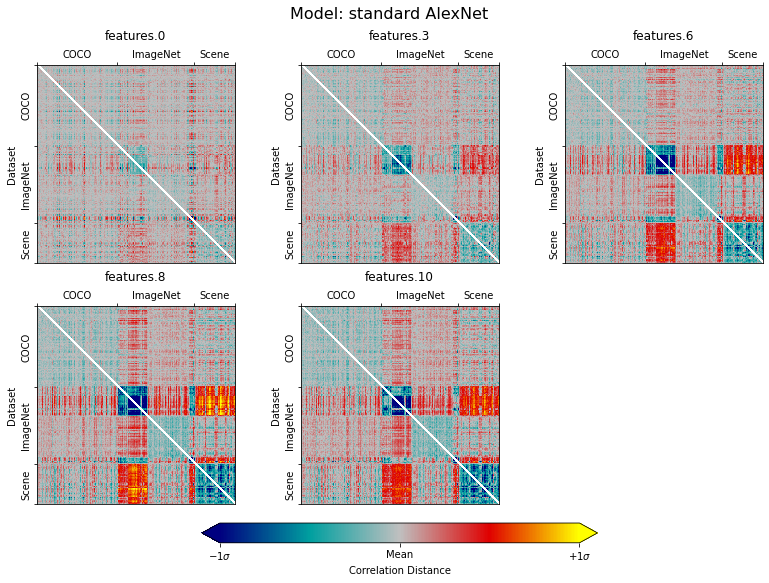

In [13]:
fig = plt.figure(figsize=(11,8), facecolor='white', constrained_layout=True)
plot_rdms(rdms, fig=fig, colorbar=True)

### EfficientNet B0

In [135]:
rdms = rsatoolbox.rdm.rdms.load_rdm('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000r2/rdms/BOLD5000/standard_efficientnet_b0/standard_efficientnet_b0.h5')

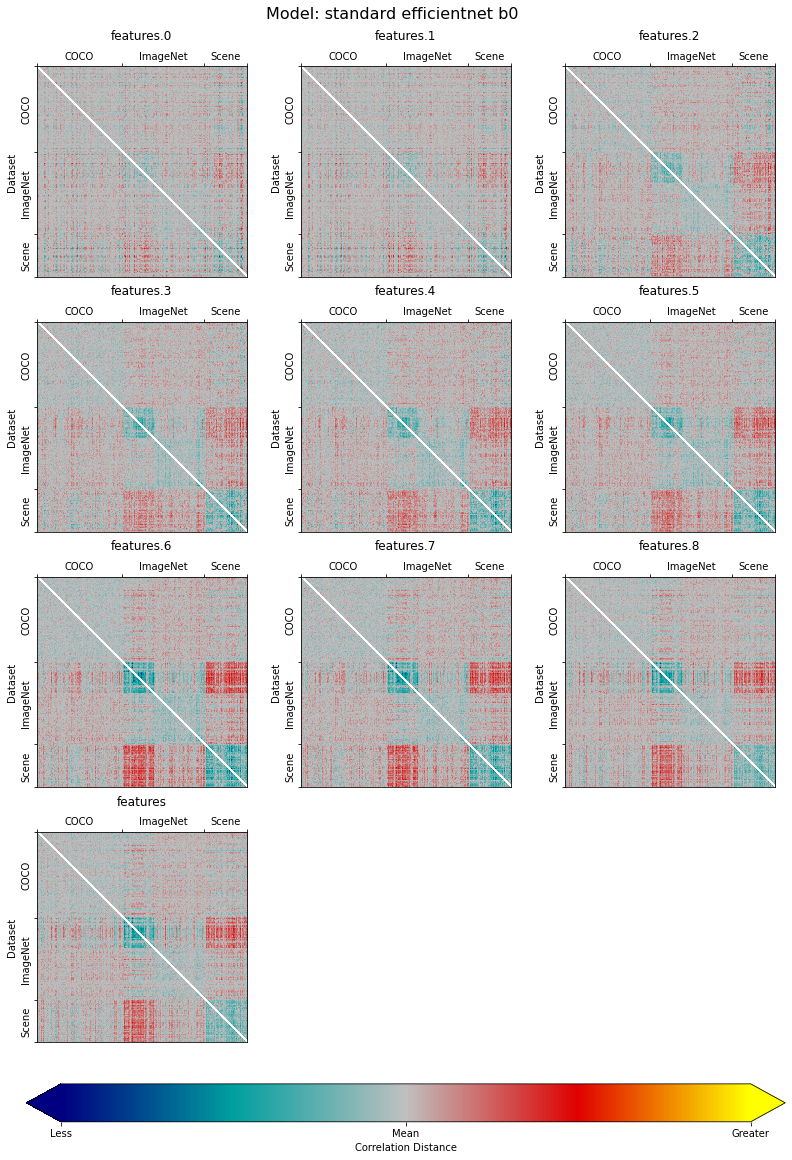

In [138]:
fig = plt.figure(figsize=(11, 16), facecolor='white', constrained_layout=True)
plot_rdms(rdms, fig=fig)

### Resnet50

In [142]:
rdms = rsatoolbox.rdm.rdms.load_rdm('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000r2/rdms/BOLD5000/standard_ResNet50/standard_ResNet50.h5')

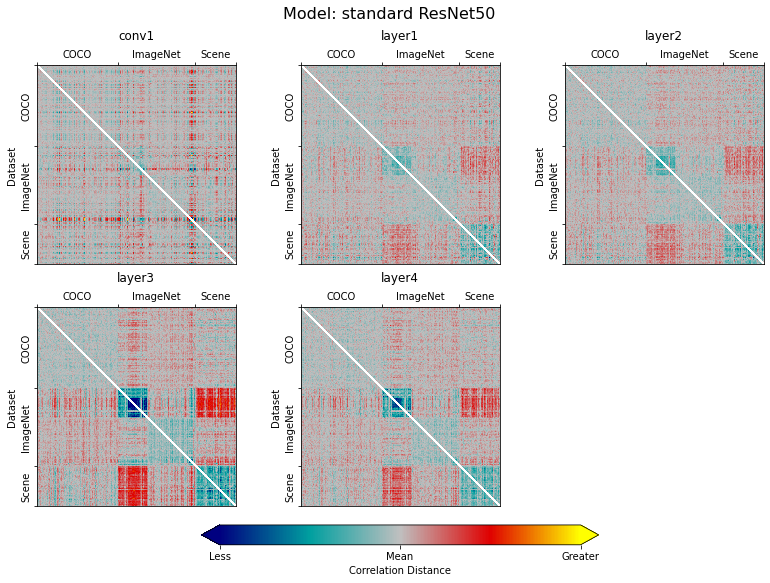

In [143]:
fig = plt.figure(figsize=(11, 8), facecolor='white', constrained_layout=True)
plot_rdms(rdms, fig=fig)

### Timm ResNet18

In [146]:
rdms = rsatoolbox.rdm.rdms.load_rdm('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000r2/rdms/BOLD5000/standard_ResNet18/standard_ResNet18.h5')

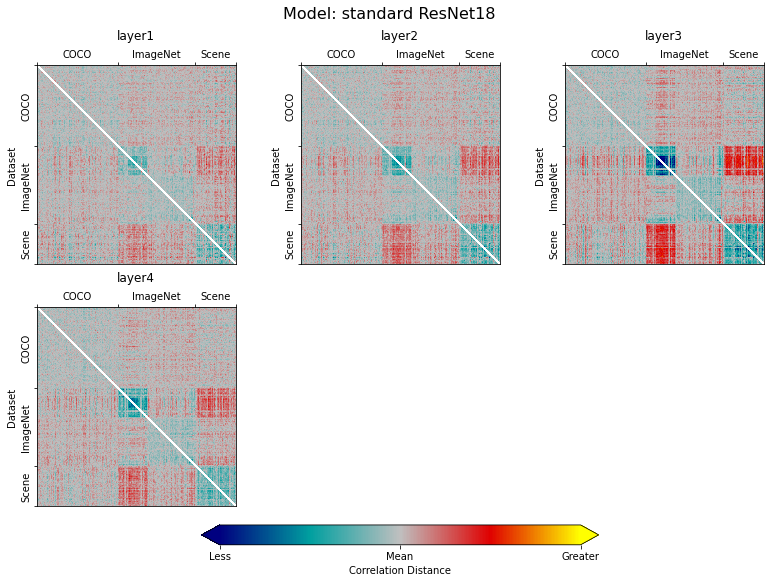

In [147]:
fig = plt.figure(figsize=(11, 8), facecolor='white', constrained_layout=True)
plot_rdms(rdms, fig=fig)

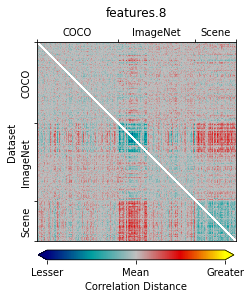

In [17]:
plot_rdm(rdms[-2])

In [38]:
model_path = dataset_v2 / 'rdms' / 'BOLD5000' / 'standard_ResNet18'

layer_names = []
rdms = []
for layer in model_path.glob('*.npz'):
    layer_names.append(layer.stem)
    with np.load(layer) as data:
        rdms.append(data['arr_0'])

In [40]:
activations = glob.glob(str(dataset_v2 / 'feats' / 'BOLD5000' / 'standard_VGG16_bn') + "/*" + ".npz")
activations.sort()
images = [Path(p).with_suffix('.jpg').name for p in activations]

rdms = rsatoolbox.rdm.RDMs(
    np.array(rdms),
    dissimilarity_measure = 'correlation',
    rdm_descriptors = {'layer' : layer_names},
    pattern_descriptors = {'image': images}
)

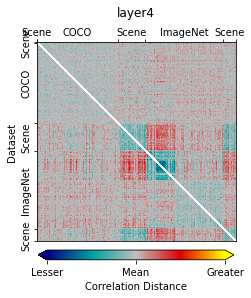

In [42]:
plot_rdm(rdms[3])

In [43]:
sort_rdms(rdms)

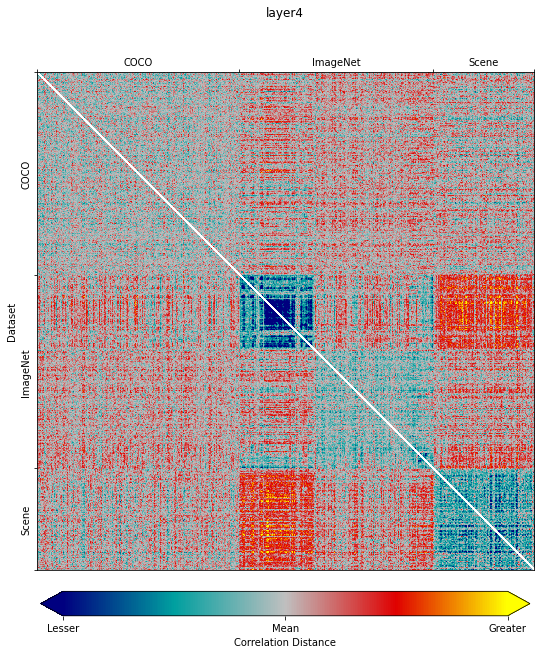

In [55]:
fig, ax = plt.subplots(figsize=(10,10))
plot_rdm(rdms[3], ax=ax)

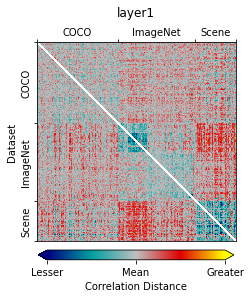

In [56]:
plot_rdm(rdms[0])

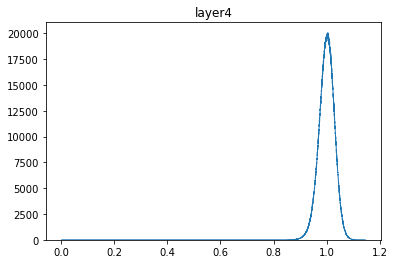

In [53]:
plot_histogram(rdms[3])

In [57]:
model_path = dataset_v2 / 'rdms' / 'BOLD5000' / 'standard_AlexNet'

layer_names = []
rdms = []
for layer in model_path.glob('*.npz'):
    layer_names.append(layer.stem)
    with np.load(layer) as data:
        rdms.append(data['arr_0'])
        
activations = glob.glob(str(dataset_v2 / 'feats' / 'BOLD5000' / 'standard_VGG16_bn') + "/*" + ".npz")
activations.sort()
images = [Path(p).with_suffix('.jpg').name for p in activations]

alexnet_rdms = rsatoolbox.rdm.RDMs(
    np.array(rdms),
    dissimilarity_measure = 'correlation',
    rdm_descriptors = {'layer' : layer_names},
    pattern_descriptors = {'image': images}
)

In [60]:
sort_rdms(alexnet_rdms)

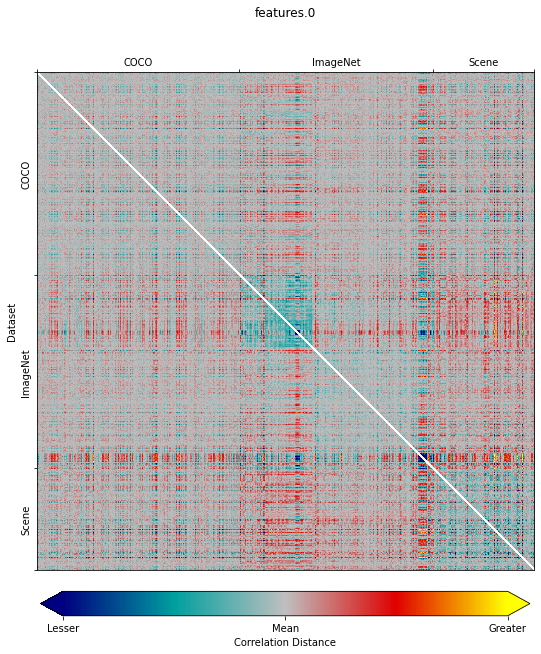

In [64]:
fig, ax = plt.subplots(figsize=(10,10))
plot_rdm(alexnet_rdms[-1], ax=ax)

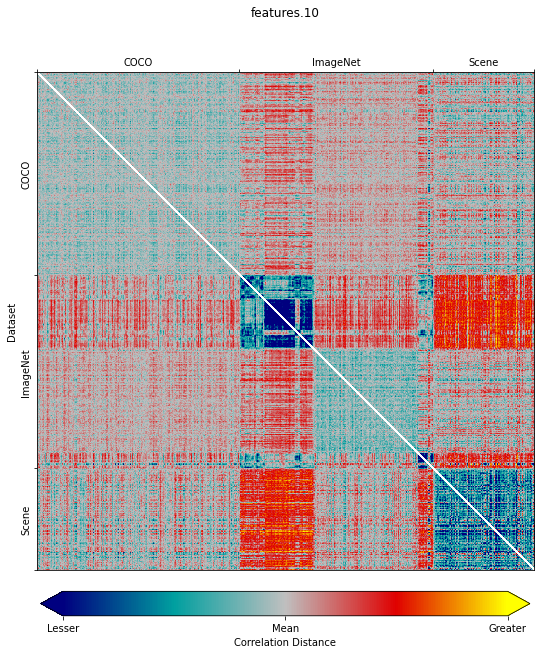

In [69]:
fig, ax = plt.subplots(figsize=(10,10))
plot_rdm(alexnet_rdms[0], ax=ax)